In [12]:
import os
import sys
import random
import time
import pickle
import pandas
import numpy as np
import matplotlib.pyplot as mplot
import seaborn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
import sagemaker
import boto3
from sagemaker.tensorflow import TensorFlow

sys.path.append('../tools/')
import sound_tools
import utils

In [13]:
# inicjalizacja:
%matplotlib inline
mplot.style.use('Solarize_Light2')
random.seed(508)
np.random.seed(508)
sess = sagemaker.Session()
role = sagemaker.get_execution_role()

DATA           = os.path.join('data', 'temp')
PROCESSED_DATA = os.path.join('data', 'processed')

In [14]:
n_mels = 128
frames = 5
n_fft = 2048
hop_length = 512
power = 2.0
blue = '#1520A6' #azure
red = '#ff1a1a'

In [15]:
########budowa zbiorów danych
#funkcja pomocniczna przyporządkowująca do zbiorów danych

def build_files_list(root_dir, abnormal_dir='abnormal', normal_dir='normal'):
    normal_files = []
    abnormal_files = []
    for root, dirs, files in os.walk(top = os.path.join(root_dir)):
        for name in files:
            current_dir_type = root.split('/')[-1]
            if current_dir_type == abnormal_dir:
                abnormal_files.append(os.path.join(root, name))
            if current_dir_type == normal_dir:
                normal_files.append(os.path.join(root, name))
    return normal_files, abnormal_files

normal_files, abnormal_files = build_files_list(root_dir=os.path.join(DATA, 'fan'))

X = np.concatenate((normal_files, abnormal_files), axis=0)
y = np.concatenate((np.zeros(len(normal_files)), np.ones(len(abnormal_files))), axis=0)

train_files, test_files, train_labels, test_labels = train_test_split(X, y,
                                                                      train_size=0.85,
                                                                      random_state=508,
                                                                      shuffle=True,
                                                                      stratify=y
                                                                     )
dataset = dict({
    'train_files': train_files,
    'test_files': test_files,
    'train_labels': train_labels,
    'test_labels': test_labels
})

for key, values in dataset.items():
    fname = os.path.join(PROCESSED_DATA, key + '.txt')
    with open(fname, 'w') as f:
        for item in values:
            f.write(str(item))
            f.write('\n')

train_files = [f for f in train_files if f not in abnormal_files]
train_labels = np.zeros(len(train_files))
print("liczba plików w zbiorze treningowym:")
print(len(train_files))
print("liczba plików w zbiorze testowym:")
print(len(test_files))

number of train files:
3463
number of test files:
833


### Ekstrakcja cech przy pomocy spektrogramów Mela

In [16]:

def extract_signal_features(signal, sr, n_mels=64, frames=5, n_fft=1024, hop_length=512):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    dims = frames * n_mels
    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)
    
    features = np.zeros((features_vector_size, dims), np.float32)
    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t:t + features_vector_size].T
    return features

def generate_dataset(files_list, n_mels=64, frames=5, n_fft=1024, hop_length=512):
    dims = n_mels * frames
    
    for index in tqdm(range(len(files_list)), desc='Extracting features'):
        signal, sr = sound_tools.load_sound_file(files_list[index])
        
        features = sound_tools.extract_signal_features(
            signal, 
            sr, 
            n_mels=n_mels, 
            frames=frames, 
            n_fft=n_fft, 
            hop_length=hop_length
        )
        
        if index == 0:
            dataset = np.zeros((features.shape[0] * len(files_list), dims), np.float32)
            
        dataset[features.shape[0] * index : features.shape[0] * (index + 1), :] = features
    return dataset

train_data_location = os.path.join(DATA, 'autoenkoder_data.pkl')

if os.path.exists(train_data_location):
    print('dane już istnieją...')
    with open(train_data_location, 'rb') as f:
        train_data = pickle.load(f)
else:
    train_data = generate_dataset(train_files, n_mels=n_mels, frames=frames, n_fft=n_fft, hop_length=hop_length)
    with open(os.path.join(DATA, 'autoenkoder_data.pkl'), 'wb') as f:
        pickle.dump(train_data, f)

autoenkoder_data already exists...


In [17]:
sess = sagemaker.Session()
training_path = sess.upload_data(os.path.join(DATA, 'autoenkoder_data.pkl'), key_prefix='training')
print(training_path)

s3://sagemaker-us-east-1-498219726579/training/autoenkoder_data.pkl


## Tworzenie modelu Tensorflow
---
### Definicja estymatora

In [39]:
#użycie estymatora z pliku
!pygmentize ../autoencoder/model.py

import argparse, os
import numpy as np
import pickle

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model

def autoencoder_model(input_dims):
    #Część enkoder
    inputLayer = Input(shape=(input_dims,))
    encoder = Dense(128, activation="relu")(inputLayer)
    encoder = Dense(64, activation="relu")(encoder)
    encoder = Dense(32, activation="relu")(encoder)
    encoder = Dense(8, activation="relu")(encoder)
    
    #Część dekoder
    encoder = Dense(32, activation="relu")(encoder)
    decoder = Dense(64, activation="relu")(encoder)
    decoder = Dense(128, activation="relu")(decoder)
    decoder = Dense(input_dims, activation=None)(decoder)

    return Model(inputs=inputLayer, outputs=decoder)


# epochs = 30
# n_mels = 12

In [61]:
tf_estimator = TensorFlow(
    base_job_name='sound-anomaly',
    entry_point='model.py',
    source_dir='../autoencoder/',
    role=role,
    instance_count=1, 
    instance_type='ml.m4.4xlarge',
    framework_version='2.2',
    py_version='py37',
    hyperparameters={
        'epochs': 30,
        'batch-size': 512,
        'learning-rate': 1e-3,
        'n_mels': n_mels,
        'frame': frames
    },
    debugger_hook_config=False
)

### Trenowanie modelu
tf_estimator.fit({'training': training_path})

In [107]:
tf_endpoint_name = 'sound-anomaly-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
tf_predictor = tf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.large',
    endpoint_name=tf_endpoint_name
)
print(f'\nNazwa endpointu: {tf_predictor.endpoint_name}')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!
Nazwa endpointu: sound-anomaly-2022-04-27-13-25-28


## Ewaluacja modelu

### Sprawdzenie wyników osiąganych przez system na zbiorze testowym 

In [108]:
y_true = test_labels
reconstruction_errors = []

for index, eval_filename in tqdm(enumerate(test_files), total=len(test_files)):
    
    signal, sr = sound_tools.load_sound_file(eval_filename)
    print(eval_filename)
    # Ekstrakcja cech z sygnału:
    eval_features = sound_tools.extract_signal_features(
        signal, 
        sr, 
        n_mels=n_mels, 
        frames=frames, 
        n_fft=n_fft, 
        hop_length=hop_length
    )
    
    # Pobieranie predykcji jako wyniku działania autoenkodera:
    prediction = tf_predictor.predict(eval_features)['predictions']
    
    # Obliczanie błędu rekonstrukcji:
    mse = np.mean(np.mean(np.square(eval_features - prediction), axis=1))
    reconstruction_errors.append(mse)

100%|██████████| 833/833 [05:40<00:00,  2.44it/s]


### Analiza błędów rekonstrukcji

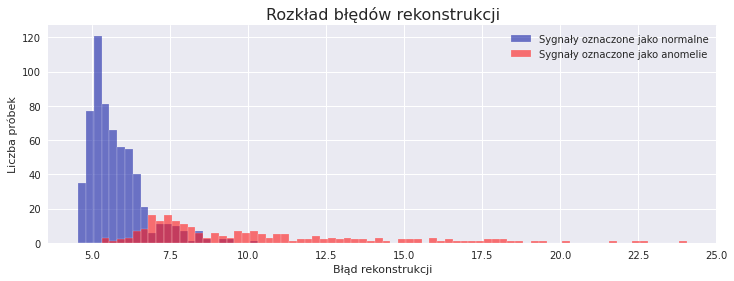

In [65]:
data = np.column_stack((range(len(reconstruction_errors)), reconstruction_errors))
bin_width = 0.25
bins = np.arange(min(reconstruction_errors), max(reconstruction_errors) + bin_width, bin_width)

fig = mplot.figure(figsize=(12,4))
mplot.hist(data[y_true==0][:,1], bins=bins, color=blue, alpha=0.6, label='Sygnały oznaczone jako normalne', edgecolor='#FFFFFF')
mplot.hist(data[y_true==1][:,1], bins=bins, color=red, alpha=0.6, label='Sygnały oznaczone jako anomelie', edgecolor='#FFFFFF')
mplot.xlabel("Błąd rekonstrukcji")
mplot.ylabel("Liczba próbek")
mplot.title('Rozkład błędów rekonstrukcji', fontsize=16)
mplot.legend()
mplot.show()

In [66]:
threshold_min = 5.0
threshold_max = 10.0
threshold_step = 0.50

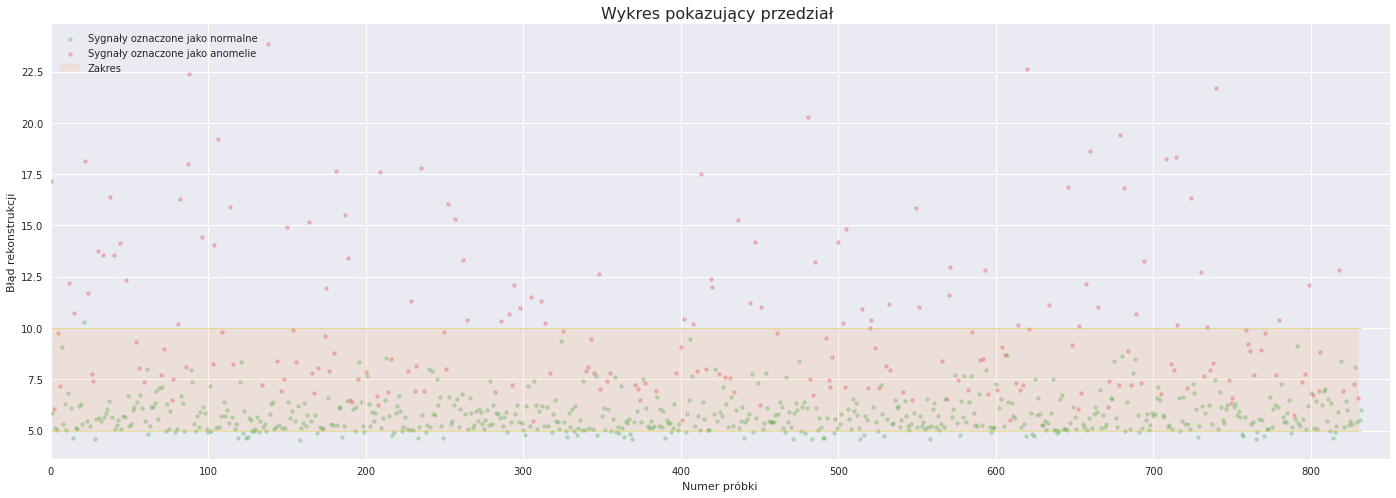

In [67]:
normal_x, normal_y = data[y_true==0][:,0], data[y_true==0][:,1]
abnormal_x, abnormal_y = data[y_true==1][:,0], data[y_true==1][:,1]
x = np.concatenate((normal_x, abnormal_x))

fig, ax = mplot.subplots(figsize=(24,8))
mplot.scatter(normal_x, normal_y, s=15, color='tab:green', alpha=0.3, label='Sygnały oznaczone jako normalne')
mplot.scatter(abnormal_x, abnormal_y, s=15, color='tab:red', alpha=0.3,   label='Sygnały oznaczone jako anomelie')
mplot.fill_between(x, threshold_min, threshold_max, alpha=0.1, color='tab:orange', label='Zakres')
mplot.hlines([threshold_min, threshold_max], x.min(), x.max(), linewidth=0.5, alpha=0.8, color='tab:olive')
mplot.legend(loc='upper left')
mplot.title('Wykres pokazujący przedział ', fontsize=16)
mplot.xlabel('Numer próbki')
mplot.ylabel('Błąd rekonstrukcji')
mplot.xlim([0,850])
mplot.show()

### Analiza i interpretacja otrzymanych wyników

In [101]:
thresholds = np.arange(threshold_min, threshold_max + threshold_step, threshold_step)

df = pandas.DataFrame(columns=['Signal', 'Ground Truth', 'Prediction', 'Reconstruction Error'])
df['Signal'] = test_files
df['Ground Truth'] = test_labels
df['Reconstruction Error'] = reconstruction_errors

FN = []
FP = []
for th in thresholds:
    df.loc[df['Reconstruction Error'] <= th, 'Prediction'] = 0.0
    df.loc[df['Reconstruction Error'] > th, 'Prediction'] = 1.0
    df = utils.generate_error_types(df)
    FN.append(df['FN'].sum())
    FP.append(df['FP'].sum())

def plot_curves(FP, FN, nb_samples, threshold_min, threshold_max, threshold_step):
    fig = mplot.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    min_FN = np.argmin(FN)
    min_FP = np.where(FP == np.min(FP))[0][-1]
    plot_top = max(FP + FN) + 1
    major_ticks = np.arange(threshold_min, threshold_max, 1.0 * threshold_step)
    minor_ticks = np.arange(threshold_min, threshold_max, 0.2 * threshold_step)
    ax.set_xticks(major_ticks);
    ax.set_xticks(minor_ticks, minor=True);
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=1.0, linewidth=1.0)
    
    mplot.plot(np.arange(threshold_min, threshold_max + threshold_step, threshold_step), FP, label='Fałszywie pozytywne', color='tab:red')
    mplot.plot(np.arange(threshold_min, threshold_max + threshold_step, threshold_step), FN, label='Fałszywie negatywne', color='tab:green')

    mplot.xlabel('Przedział błędu rekonstrukcji [%]', fontsize=16)
    mplot.ylabel('Liczba próbek', fontsize=16)
    mplot.legend()
    

plot_curves(FP, FN, nb_samples=df.shape[0], threshold_min=threshold_min, threshold_max=threshold_max, threshold_step=threshold_step)

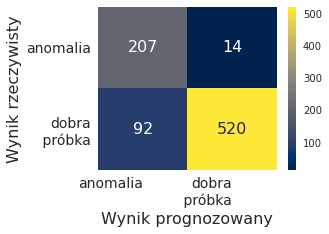

In [106]:
## Analiza wyników i rysowanie tablicy prawdy

th = 6.5
df.loc[df['Reconstruction Error'] <= th, 'Prediction'] = 0.0
df.loc[df['Reconstruction Error'] > th, 'Prediction'] = 1.0
df['Prediction'] = df['Prediction'].astype(np.float32)
df = utils.generate_error_types(df)
tp = df['TP'].sum()
tn = df['TN'].sum()
fn = df['FN'].sum()
fp = df['FP'].sum()

from sklearn.metrics import confusion_matrix
df['Ground Truth'] = 1 - df['Ground Truth']
df['Prediction'] = 1 - df['Prediction']

def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=14):
    df_cm = pandas.DataFrame(confusion_matrix, 
                         index=class_names, 
                         columns=class_names)
    
    fig = mplot.figure(figsize=figsize)
    try:
        heatmap = seaborn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}, cmap='cividis')
    except ValueError:
        raise ValueError("input ints")
        
    # Figure customization:
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    mplot.ylabel('Wynik rzeczywisty', fontsize=16)
    mplot.xlabel('Wynik prognozowany', fontsize=16)
    
    return fig

print_confusion_matrix(confusion_matrix(df['Ground Truth'], df['Prediction']), class_names=['anomalia', 'dobra\n próbka']);

In [97]:
df.to_csv(os.path.join(PROCESSED_DATA, 'results_autoencoder.csv'), index=False)

In [98]:
### obliczanie wskaźników

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * precision * recall / (precision + recall)
miss_rate = fn / (tp + fn)
print(f"""Podstawowe wskaźniki kwalifikacji wyników:
- precyzja: {precision*100:.1f}%
- czułość: {recall*100:.1f}%
- dokładność: {accuracy*100:.1f}%
- wynik F1: {f1_score*100:.1f}%
- fałszywie ujemne: {miss_rate*100:.1f}%""")

Podstawowe wskaźniki kwalifikacji wyników:
- precyzja: 85.0%
- czułość: 97.4%
- dokładność: 87.3%
- wynik F1: 90.8%
- fałszywie ujemne: 2.6%


In [ ]:
### usuwanie endpointu w celu oszczędności środków
sess.delete_endpoint(tf_predictor.endpoint_name)